In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('restaurant_reviews.tsv',sep='\t')
print(f'The no. of data points is {len(data)}')
print(data['Liked'].value_counts())

The no. of data points is 1000
1    500
0    500
Name: Liked, dtype: int64


In [3]:
import re

def de_html(target):
    filtered = re.sub(r'<.*>',' ',target)
    return filtered

def de_special_chars(target):
    cleaned = re.sub(r'[?|!|\'|"|#|$|@|&|%]',' ',target)
    cleaned = re.sub(r'[.|,|)|(|\\|/]',' ',cleaned)
    return cleaned

In [78]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer,WordNetLemmatizer

stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

In [79]:
negative_words = []
positive_words = []
cleaned_data = []
review_count = 0

for review in data['Review']:
    cleaned_review = []
    review = de_html(review)
    review = de_special_chars(review)
    for word in review.split():
        if word.lower() not in stop_words:
            if word.isalpha() and len(word) > 2:
                if data.iloc[review_count,-1]:
                    positive_words.append(word.lower())
                else:
                    negative_words.append(word.lower())
                # stemmed_word = stemmer.stem(word.lower())
                lem_word = lemmatizer.lemmatize(word.lower())
                cleaned_review.append(lem_word)
    cleaned_review = ' '.join(cleaned_review)
    cleaned_data.append(cleaned_review)
    review_count += 1


In [81]:
from nltk import FreqDist
frequency = FreqDist(negative_words)
print(frequency.most_common(10))

[('food', 66), ('place', 49), ('back', 38), ('service', 38), ('like', 29), ('good', 22), ('would', 22), ('never', 22), ('time', 20), ('ever', 19)]


In [82]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
word_model = CountVectorizer(ngram_range=(1,2),binary=True)
# word_model = TfidfVectorizer()
bag_of_words = word_model.fit_transform(cleaned_data)
target_labels = data.iloc[:,-1].values

In [83]:
from sklearn.model_selection import train_test_split
ind_train,ind_test,dep_train,dep_test = train_test_split(bag_of_words,target_labels,test_size=0.2,random_state=0)

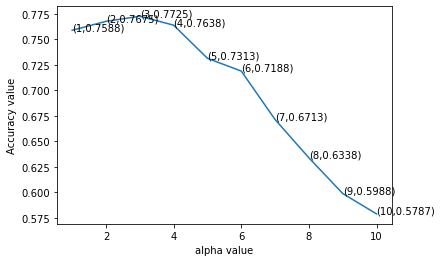

In [84]:

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
import matplotlib.pyplot as plt
from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression

alpha_values = list(range(1,11))
# c_values = [1e-4,1e-3,1e-2,1e-1,1,10,100,1000,1e4]
# gamma_values = [1e-4,1e-3,1e-2,1e-1,1,10,100,1000,1e4]
# gamma_values = list(range(1,6))
# c_values = [1e-4,1e-3,1e-2,1e-1,1]
acc_values = []

max_ac = 0
max_c = -1
max_gam = -1

for alph in alpha_values:
    # for gam in gamma_values:
    # model = SVC(random_state=0,kernel='poly',C=alph,degree=gam)
    model = BernoulliNB(alpha=alph)
    # model = LogisticRegression(penalty='elasticnet',l1_ratio=alph,solver='saga')
    accuracy_result = cross_val_score(model,ind_train,dep_train,cv=10,scoring='accuracy')
    # if accuracy_result.mean() > max_ac:
    #     max_ac = accuracy_result.mean()
    #     max_c = alph
    #     max_gam = gam
        
    acc_values.append(accuracy_result.mean())

plt.plot(alpha_values,acc_values)

for alph,acc in list(zip(alpha_values,acc_values)):
    plt.annotate(f'({alph},{acc:.4f})',xy=(alph,acc))

plt.xlabel('alpha value')
plt.ylabel('Accuracy value')
plt.show()
# print(f'The optimal C value is {max_c}')
# print(f'The optimal degree value is {max_gam}')
# print(f'The max accuracy is {max_ac}')

In [64]:
print(alpha_values[acc_values.index(max(acc_values))])

1


In [85]:
model = BernoulliNB(alpha=3)
# model = SVC(kernel='poly',C=10,degree=2,random_state=0,probability=True)
# model = LogisticRegression(penalty='elasticnet',l1_ratio=0.0001,solver='saga')
model.fit(ind_train,dep_train)
results = model.predict(ind_test)

In [86]:

from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
matrix = confusion_matrix(dep_test,results)
accuracy_score = accuracy_score(dep_test,results)

probs_result = model.predict_proba(ind_test)
max_label_probs = probs_result[:,1]
    
auc_score = roc_auc_score(dep_test,max_label_probs)

print(f'The confusion matrix looks like:\n {matrix}')
print(f'The accuracy score is {accuracy_score}')
print(f'The AUC score is {auc_score}')

The confusion matrix looks like:
 [[78 19]
 [31 72]]
The accuracy score is 0.75
The AUC score is 0.8415073566209588


In [67]:


#binary BOW, bernoulliNB(alpha =3), unigrams,bigrams:
# The confusion matrix looks like:
#  [[81 16]
#  [26 77]]
# The accuracy score is 0.79
# The AUC score is 0.8529676709038134

#Non-binary BOW, mutinomialNB(alpha=2) , uni and bigrams:
# The confusion matrix looks like:
#  [[72 25]
#  [21 82]]
# The accuracy score is 0.77
# The AUC score is 0.8613251926734061

#Non-binary BOW, mutinomialNB(alpha=2) , uni,bi and trigrams:
# The confusion matrix looks like:
#  [[71 26]
#  [20 83]]
# The accuracy score is 0.77
# The AUC score is 0.862876588930037

